In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
import scipy.stats
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
gender = 'WTA'

In [3]:
if gender == 'ATP':
    df = pd.read_csv('/Users/anika/Desktop/BEM:EC 120/generated_datasets/atp_all_rally_info.csv')
else:
    df = pd.read_csv('/Users/anika/Desktop/BEM:EC 120/generated_datasets/wta_all_rally_info.csv')

In [4]:
if gender == 'ATP':
    github_url_match_data = "https://raw.githubusercontent.com/JeffSackmann/tennis_MatchChartingProject/refs/heads/master/charting-m-matches.csv"
    df_return_outcomes = pd.read_csv("https://raw.githubusercontent.com/JeffSackmann/tennis_MatchChartingProject/refs/heads/master/charting-m-stats-ReturnOutcomes.csv")
    df_serve_outcomes = pd.read_csv("https://raw.githubusercontent.com/JeffSackmann/tennis_MatchChartingProject/refs/heads/master/charting-m-stats-ServeBasics.csv")
    df_return_depth = pd.read_csv("https://raw.githubusercontent.com/JeffSackmann/tennis_MatchChartingProject/refs/heads/master/charting-m-stats-ReturnDepth.csv")
    df_serve_key_pts = pd.read_csv("https://raw.githubusercontent.com/JeffSackmann/tennis_MatchChartingProject/refs/heads/master/charting-m-stats-KeyPointsServe.csv")
    df_player_stats = pd.read_csv("https://raw.githubusercontent.com/JeffSackmann/tennis_atp/refs/heads/master/atp_players.csv")
    df_matches = pd.read_csv(github_url_match_data)
else:
    github_url_match_data = "https://raw.githubusercontent.com/JeffSackmann/tennis_MatchChartingProject/refs/heads/master/charting-w-matches.csv"
    df_return_outcomes = pd.read_csv("https://raw.githubusercontent.com/JeffSackmann/tennis_MatchChartingProject/refs/heads/master/charting-w-stats-ReturnOutcomes.csv")
    df_serve_outcomes = pd.read_csv("https://raw.githubusercontent.com/JeffSackmann/tennis_MatchChartingProject/refs/heads/master/charting-w-stats-ServeBasics.csv")
    df_return_depth = pd.read_csv("https://raw.githubusercontent.com/JeffSackmann/tennis_MatchChartingProject/refs/heads/master/charting-w-stats-ReturnDepth.csv")
    df_serve_key_pts = pd.read_csv("https://raw.githubusercontent.com/JeffSackmann/tennis_MatchChartingProject/refs/heads/master/charting-w-stats-KeyPointsServe.csv")
    df_player_stats = pd.read_csv("https://raw.githubusercontent.com/JeffSackmann/tennis_wta/refs/heads/master/wta_players.csv")
    df_matches = pd.read_csv(github_url_match_data)

df_player_stats['player'] = (
    (df_player_stats['name_first'] + ' ' + df_player_stats['name_last'])
    .str.lower()
    .str.replace('-', ' ', regex=False)
)
player_stats_dict = df_player_stats.set_index('player')['height'].to_dict()
player_stats_dict = {k: v for k, v in player_stats_dict.items() if not pd.isna(v)}
heights = [val for val in player_stats_dict.values()]
avg_height = np.mean(heights)

/Users/anika/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
# Add the columns Surface, Date, Pl 1 hand, Pl 2 hand
df = pd.merge(df, df_matches[['match_id', 'Surface', 'Date', 'Pl 1 hand', 'Pl 2 hand']], on='match_id')

In [6]:
# get types of all columns
df.dtypes

match_id                object
player1                 object
player2                 object
server                   int64
pt_number                int64
game_score              object
side                    object
game_number              int64
player1_sets             int64
player2_sets             int64
player1_games_in_set     int64
player2_games_in_set     int64
1st                     object
2nd                     object
pt_winner                int64
rally_length             int64
error_type              object
Surface                 object
Date                    object
Pl 1 hand               object
Pl 2 hand               object
dtype: object

In [7]:
# convert df['1st'] and df['2nd'] to a list of dictionaries
df['1st'] = df['1st'].apply(lambda x: eval(x) if isinstance(x, str) else None)
df['2nd'] = df['2nd'].apply(lambda x: eval(x) if isinstance(x, str) else None)

In [8]:
# Create a rally column where it is equal to df['1st'] if 1st is not none and 2nd is none, or df['2nd'] if both are not none
df['rally'] = df.apply(lambda x: x['1st'] if x['1st'] is not None and x['2nd'] is None else x['2nd'], axis=1)
df['serve_attempt'] = df.apply(lambda x: 1 if x['1st'] is not None and x['2nd'] is None else 2, axis=1)

In [9]:
# Find how many rallys do not have a serve + 1 shot, meaning that rally_length < 3
print(f'Total number of points with rally_length < 3: {df[df["rally_length"] < 3]["rally_length"].count()}')

Total number of points with rally_length < 3: 137202


In [10]:
df.columns

Index(['match_id', 'player1', 'player2', 'server', 'pt_number', 'game_score',
       'side', 'game_number', 'player1_sets', 'player2_sets',
       'player1_games_in_set', 'player2_games_in_set', '1st', '2nd',
       'pt_winner', 'rally_length', 'error_type', 'Surface', 'Date',
       'Pl 1 hand', 'Pl 2 hand', 'rally', 'serve_attempt'],
      dtype='object')

In [11]:
df['Date'] = pd.to_datetime(df['Date'])

# Reshape to long format (one row per player per match)
players_df = pd.melt(
    df[['match_id', 'Date', 'player1', 'player2']],
    id_vars=['match_id', 'Date'],
    value_vars=['player1', 'player2'],
    var_name='player_role',
    value_name='player'
)

players_df = players_df.drop_duplicates(subset=['player', 'match_id'])
player_dates = []
split_date = pd.to_datetime('2024-01-01')
evaluated_players = set()

for player, group in players_df.groupby('player'):
    sorted_matches = group.sort_values('Date')
    dates = sorted_matches['Date'].unique()
        
    # Find all players that have at least 2 matches before and 3 after the split date
    if len(dates) >= 5 and dates[1] < split_date and dates[-3] >= split_date:
        evaluated_players.add(player)

In [12]:
# Add a column to df called 'data_split' with values 'train', 'fine_tune', or 'test'
df['data_split_2024'] = None
df.loc[df['Date'] < split_date, 'data_split_2024'] = 'train'
assigned_matches = set()
train_players1 = set(df[df['data_split_2024'] == 'train']['player1'].unique())
train_players2 = set(df[df['data_split_2024'] == 'train']['player2'].unique())

# For each evaluated player, assign fine_tune and test
for player in evaluated_players:
    assert player in train_players1 or player in train_players2

    # Get all matches where the player is server and date >= split_date
    matches = df[((df['player1'] == player) | (df['player2'] == player)) & (df['Date'] >= split_date)].sort_values('Date')

    # Get match IDs in order
    match_ids = matches['match_id'].unique()

    # Skip if not enough matches
    assert len(match_ids) >= 3

    fine_tune_ids = match_ids[:2]
    test_ids = match_ids[2:]

    df.loc[df['match_id'].isin(fine_tune_ids), 'data_split_2024'] = 'test'
    df.loc[df['match_id'].isin(test_ids), 'data_split_2024'] = 'test'
    assigned_matches.update(fine_tune_ids)
    assigned_matches.update(test_ids)

Text(0.5, 1.0, 'WTA: Matches Charted by Year')

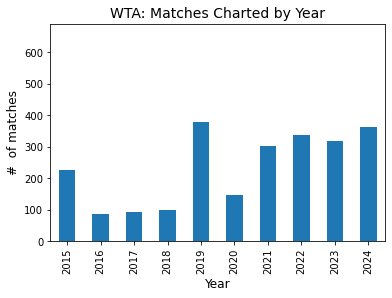

In [14]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

unique_matches = df.drop_duplicates(subset=['Date', 'match_id'])
matches_per_year = unique_matches['Date'].dt.year.value_counts()
matches_per_year = matches_per_year.sort_index()

matches_per_year.plot.bar()
# set limit from 0 to 650
plt.ylim(0, 690)
plt.xlabel('Year', fontsize=12)
plt.ylabel('#  of matches', fontsize=12)
plt.title(f'{gender}: Matches Charted by Year', fontsize=14)

In [51]:
players1 = df['player1'].unique()
players2 = df['player2'].unique()
players = np.append(players1, players2)
players = np.unique(players)
print(f'Total number of players: {len(players)}', f'Total number of matches: {df["match_id"].nunique()}', f'Total number of rallies: {len(df)}', sep = '\n')

Total number of players: 490
Total number of matches: 2353
Total number of rallies: 332480


In [91]:
def get_pt_diff(score):
    # Score is in the form '1-0' (Tiebreak) or '30-40' (Game)
    # Returns 'ad' for advantage, 'deuce' for deuce
    game_to_pts = {'0': 0, '15': 1, '30': 2, '40': 3, 'AD': 4}
    pt1, pt2 = score.split('-')

    if pt1 in game_to_pts and pt2 in game_to_pts:
        pts1 = game_to_pts[score.split('-')[0]]
        pts2 = game_to_pts[score.split('-')[1]]
    else: # Tiebreak score
        pts1 = int(pt1)
        pts2 = int(pt2)
    
    return pts1 + pts2, pts1 - pts2

def is_break_point(score):
    # Score is in the form '1-0' (Tiebreak) or '30-40' (Game)
    # Returns True if break point, False otherwise
    game_to_pts = {'0': 0, '15': 1, '30': 2, '40': 3, 'AD': 4}
    pt1, pt2 = score.split('-')

    if pt1 in game_to_pts and pt2 in game_to_pts:
        pts1 = game_to_pts[score.split('-')[0]]
        pts2 = game_to_pts[score.split('-')[1]]
    else:
        return False

    return pts2 >= 3 and pts1 < pts2

def is_game_point(score):
    # Score is in the form '1-0' (Tiebreak) or '30-40' (Game)
    # Returns True if game point, False otherwise
    game_to_pts = {'0': 0, '15': 1, '30': 2, '40': 3, 'AD': 4}
    pt1, pt2 = score.split('-')

    if pt1 in game_to_pts and pt2 in game_to_pts:
        pts1 = game_to_pts[score.split('-')[0]]
        pts2 = game_to_pts[score.split('-')[1]]
    else:
        return False

    return pts1 >= 3 and pts1 > pts2

def compute_entropy_from_list(data):
    counts = Counter(data)
    probabilities = [count / len(data) for count in counts.values()]
    return scipy.stats.entropy(probabilities)


def update_tendencies(df, match, positions, numerator_col, denominator_col, tendency_key, match_tendencies, decoder=None, is_serve=False, is_depth=False):
    # Filter and calculate the required frequency or percentage
    df_filtered = (
        df.loc[df['match_id'] == match]
        .query('row in @positions')
        .assign(
            calculated_value=lambda x: (
                x[numerator_col] / (x[numerator_col] + x[denominator_col])
                if is_depth else x[numerator_col] / x[denominator_col]
            )
        )
    )

    # Group by player and position, and convert to a dictionary
    player_position_stats = (
        df_filtered[['player', 'row', 'calculated_value']]
        .groupby(['player', 'row'])
        .first()['calculated_value']
        .to_dict()
    )

    # Update tendencies
    for (player, position), value in player_position_stats.items():
        if decoder and not is_serve:
            # Decode position for return tendencies
            tendency_subkey = decoder[position]
        else:
            # Use position directly for serve tendencies or depth tendencies
            tendency_subkey = int(position) if is_serve else position

        match_tendencies[player][tendency_key][tendency_subkey].append(value)

        # Maintain only the last 5 matches
        if len(match_tendencies[player][tendency_key][tendency_subkey]) > 8:
            match_tendencies[player][tendency_key][tendency_subkey].pop(0)

In [92]:
def featurize_match(df, match, match_tendencies={}):

    df_match = df[df['match_id'] == match]
    df_match = df_match.sort_values(by='pt_number')

    data = []
    deuces = 0

    serve_encoder = {'wide deuce': '4D', 'wide ad': '4A', 'body deuce': '5D',
                     'body ad': '5A', 'T deuce': '6D', 'T ad': '6A', 1: 'v1st', 2: 'v2nd'}
    serve_decoder = {v: k for k, v in serve_encoder.items()}

    count_good_shots = {
        1: 0,
        2: 0
    }

    last_returns_lists = {
        1: {
            'deuce': [],
            'ad': []
        },
        2: {
            'deuce': [],
            'ad': []
        }
    }

    error_lists = {
        1: [],
        2: []
    }

    last_serve_lists = {
        1: {
            'deuce': ['body'],
            'ad': ['body']
        }, 
        2: {
            'deuce': ['body'],
            'ad': ['body']
        }
    }

    last_1_lists = {
        1: ['middle'],
        2: ['middle']
    }

    entropy_s1_lists = {
        1 : {
            'deuce': [],
            'ad': []
        }, 
        2: {
            'deuce': [],
            'ad': []
        }
    }

    s1_success_lists = {
        1: {
            1: [],
            2: []
        },
        2: {
            1: [],
            2: []
        }
    }

    return1_success_lists = {
        1: {
            1: [],
            2: [],
        },
        2: {
            1: [],
            2: [],
        }
    }

    serve_success_lists = {
        1: {
            1: [],
            2: [],
            'deuce': [],
            'ad': []
        },
        2: {
            1: [],
            2: [],
            'deuce': [],
            'ad': []
        }
    }

    rally_lengths_in_won_pts = {
        1: [],
        2: []
    }

    rally_lengths_in_lost_pts = {
        1: [],
        2: []
    }

    win_streaks = {
        1: 0,
        2: 0,
    }

    total_shots_hit = {
        1: {
            'deuce court': 0,
            'ad court': 0,
            'middle': 0
        },
        2: {
            'deuce court': 0,
            'ad court': 0,
            'middle': 0
        }
    }

    double_faults = {
        1: 0,
        2: 0
    }

    unforced_errors = {
        1: 0,
        2: 0
    }

    rally_lengths = []

    for _, row in df_match.iterrows():
        server_idx = row['server']
        opponent_idx = 3 - server_idx
        server = row['player1'] if server_idx == 1 else row['player2']
        opponent = row['player1'] if server_idx == 2 else row['player2']
        server_vs_op_hand = row['Pl 1 hand'] + row['Pl 2 hand'] if server_idx == 1 else row['Pl 2 hand'] + row['Pl 1 hand']
        surface = row['Surface']
        court_side = row['side']
        pt_match = row['pt_number']
        game_adv = row['player1_sets'] - row['player2_sets'] if server_idx == 1 else row['player2_sets'] - row['player1_sets']
        set_adv = row['player1_sets'] - row['player2_sets'] if server_idx == 1 else row['player2_sets'] - row['player1_sets']
        pts_in_game, point_adv = get_pt_diff(row['game_score'])
        if row['game_score'] == '40-40':
            deuces += 1
        if pts_in_game < 6:
            deuces = 0
        if deuces > 0:
            pts_in_game += (2 * (deuces - 1))

        break_point = is_break_point(row['game_score'])
        game_point = is_game_point(row['game_score'])

        serve_loc = row['rally'][0]['location']
        if not serve_loc:
            serve_loc = 'unknown'
        first_shot_loc = row['rally'][2]['location'] if len(row['rally']) > 2 else 'no first shot'
        return_loc = row['rally'][1]['location'] if len(row['rally']) > 1 else 'no return'

        won_pt = row['pt_winner'] == server_idx
        first_serve_attempt = None
        if row['2nd'] and row['1st']:
            first_serve_attempt = row['1st'][0]['location']
        elif row['2nd'] is None:
            first_serve_attempt = 'made first serve'

        forced_err = True if row['error_type'] == 'forced' and won_pt else False

        rally_length = 'no rally'
        if 0 < row['rally_length'] <= 5:
            rally_length = 'short'
        if row['rally_length'] > 5:
            rally_length = 'medium'
        if row['rally_length'] > 10:
            rally_length = 'long'

        returner_success_serve = 0
        if row['serve_attempt'] == 1 and match_tendencies[opponent]['return_err'][1]:
            returner_success_serve = np.mean(match_tendencies[opponent]['return_err'][1])
        elif row['serve_attempt'] == 2 and match_tendencies[opponent]['return_err'][2]:
            returner_success_serve = np.mean(match_tendencies[opponent]['return_err'][2])

        wide_server_win_rate, body_server_win_rate, T_server_win_rate = 0, 0, 0
        if len(serve_success_lists[server_idx][court_side]) > 0:
            wide_server_win_rate = serve_success_lists[server_idx][court_side].count('wide') / len(serve_success_lists[server_idx][court_side])
            body_server_win_rate = serve_success_lists[server_idx][court_side].count('body') / len(serve_success_lists[server_idx][court_side])
            T_server_win_rate = serve_success_lists[server_idx][court_side].count('T') / len(serve_success_lists[server_idx][court_side])

        height_server = avg_height if server.lower() not in player_stats_dict else player_stats_dict[server.lower()]
        height_opponent = avg_height if opponent.lower() not in player_stats_dict else player_stats_dict[opponent.lower()]

        data.append({
            'match_id': match,
            'server': server,
            'opponent': opponent,
            'hand_combo': server_vs_op_hand,
            'height': height_server,
            'height_difference': height_server - height_opponent,
            'surface': surface,
            'game_advantage': game_adv,
            'set_advantage': set_adv,
            'point_advantage': point_adv,
            'pts_in_game': pts_in_game,
            'pts_in_match': pt_match,
            'is_break_point': break_point,
            'is_game_point': game_point,
            'double_fault_rate': double_faults[server_idx] / pt_match,
            'unforced_err_diff': (unforced_errors[server_idx] - unforced_errors[opponent_idx]) / pt_match,
            'op_pct_errors_deuce_side': error_lists[opponent_idx].count('deuce court') / len(error_lists[opponent_idx]) if error_lists[opponent_idx] else 0,
            'op_pct_errors_ad_side': error_lists[opponent_idx].count('ad court') / len(error_lists[opponent_idx]) if error_lists[opponent_idx] else 0,
            'op_pct_errors_middle': error_lists[opponent_idx].count('middle') / len(error_lists[opponent_idx]) if error_lists[opponent_idx] else 0,
            'op_pct_shots_errors_deuce_side': error_lists[opponent_idx].count('deuce court') / total_shots_hit[opponent_idx]['deuce court'] if total_shots_hit[opponent_idx]['deuce court'] else 0,
            'op_pct_shots_errors_ad_side': error_lists[opponent_idx].count('ad court') / total_shots_hit[opponent_idx]['ad court'] if total_shots_hit[opponent_idx]['ad court'] else 0,
            'op_pct_shots_errors_middle': error_lists[opponent_idx].count('middle') / total_shots_hit[opponent_idx]['middle'] if total_shots_hit[opponent_idx]['middle'] else 0,
            's1_success_rate_whole_match': np.mean(s1_success_lists[server_idx][row['serve_attempt']]) if s1_success_lists[server_idx][row['serve_attempt']] else 0,
            'return1_success_rate_whole_match': np.mean(return1_success_lists[opponent_idx][row['serve_attempt']]) if return1_success_lists[opponent_idx][row['serve_attempt']] else 0,
            'wide_returner_win_recent_matches': np.mean(match_tendencies[opponent]['return_err'][f'wide {court_side}']) if match_tendencies[opponent]['return_err'][f'wide {court_side}'] else 0,
            'body_returner_win_recent_matches': np.mean(match_tendencies[opponent]['return_err'][f'body {court_side}']) if match_tendencies[opponent]['return_err'][f'body {court_side}'] else 0,
            'T_returner_win_recent_matches': np.mean(match_tendencies[opponent]['return_err'][f'T {court_side}']) if match_tendencies[opponent]['return_err'][f'T {court_side}'] else 0,
            'wide_server_win_rate': wide_server_win_rate,
            'body_server_win_rate': body_server_win_rate,
            'T_server_win_rate': T_server_win_rate,
            '1st/2nd_server_win_rate': np.mean(serve_success_lists[server_idx][row['serve_attempt']]) if serve_success_lists[server_idx][row['serve_attempt']] else 0,
            'good_pts_server_minus_opp': (count_good_shots[server_idx] - count_good_shots[opponent_idx]) / pt_match, 
            'returner_win_1st/2nd_recent_matches': returner_success_serve,
            's1_success_recent_matches': np.mean(match_tendencies[server]['serve_s1_success'][row['serve_attempt']]) if match_tendencies[server]['serve_s1_success'][row['serve_attempt']] else 0,
            'returner_depth_recent_matches_1st/2nd': np.mean(match_tendencies[opponent]['return_depth'][row['serve_attempt']]) if match_tendencies[opponent]['return_depth'][row['serve_attempt']] else 0,
            'returner_depth_recent_matches_wide': np.mean(match_tendencies[opponent]['return_depth'][f'wide {court_side}']) if match_tendencies[opponent]['return_depth'][f'wide {court_side}'] else 0,
            'returner_depth_recent_matches_body': np.mean(match_tendencies[opponent]['return_depth'][f'body {court_side}']) if match_tendencies[opponent]['return_depth'][f'body {court_side}'] else 0,
            'returner_depth_recent_matches_T': np.mean(match_tendencies[opponent]['return_depth'][f'T {court_side}']) if match_tendencies[opponent]['return_depth'][f'T {court_side}'] else 0,
            'server_combo_predictability_last10': compute_entropy_from_list(entropy_s1_lists[server_idx][court_side][-10:]),
            'serve_predictability_last10': compute_entropy_from_list(last_serve_lists[server_idx][court_side][-10:]),
            'return_predictability_last10': compute_entropy_from_list(last_returns_lists[opponent_idx][court_side][-10:]),
            'server_gp_won_recent_matches': np.mean(match_tendencies[server]['serve_key_point']['GP']) if match_tendencies[server]['serve_key_point']['GP'] else 0,
            'server_bp_saved_recent_matches': np.mean(match_tendencies[server]['serve_key_point']['BP']) if match_tendencies[server]['serve_key_point']['BP'] else 0,
            'same_serve_last': True if serve_loc == last_serve_lists[server_idx][court_side][-1] else False,
            'same_shot_last': True if first_shot_loc == last_1_lists[server_idx][-1] else False,
            'rally_intensity_last10': np.mean(rally_lengths[-10:]),
            'rally_lengths_won_pts': np.mean(rally_lengths_in_won_pts[server_idx]) if rally_lengths_in_won_pts[server_idx] else 0,
            'rally_lengths_lost_pts': np.mean(rally_lengths_in_lost_pts[server_idx]) if rally_lengths_in_lost_pts[server_idx] else 0,
            'win_streak_server': win_streaks[server_idx],
            'win_streak_opponent': win_streaks[opponent_idx],
            'last_serve': last_serve_lists[server_idx][court_side][-1],
            'last_1_shot': last_1_lists[server_idx][-1],
            'court_side': court_side,
            'first_serve_attempt': first_serve_attempt,
            'serve_loc': serve_loc,
            'first_shot_loc': first_shot_loc,
            'won_pt': won_pt,
            'is_forced_err': forced_err,
            'rally_category': rally_length,
            'rally_length': row['rally_length'],
            's1_success': rally_length == 'short' and won_pt,
            'data_split_2024': row['data_split_2024'],
        })

        if row['rally_length']== 0 and row['server'] != row['pt_winner']:
            double_faults[server_idx] += 1
      
        if len(row['rally']) > 2:
            if row['rally'][-1]['unreturnable'] and row['rally'][-1]['player'] == row['pt_winner']:
                count_good_shots[row['pt_winner']] += 1
                if row['rally'][-1]['location'] and any(loc in row['rally'][-1]['location'] for loc in ['deuce', 'ad', 'mid']):
                    error_lists[3 - row['rally'][-1]['player']].append(row['rally'][-1]['location'])
            if row['rally'][-2]['location'] and row['rally'][-2]['player'] == row['pt_winner']:
                if row['rally'][-1]['error_type'] == 'forced':
                    count_good_shots[row['pt_winner']] += 1
                if row['rally'][-1]['error_type'] == 'unforced':
                    unforced_errors[row['rally'][-1]['player']] += 1
                if any(loc in row['rally'][-2]['location'] for loc in ['deuce', 'ad', 'mid']):
                    error_lists[3 - row['rally'][-2]['player']].append(row['rally'][-2]['location'])

        s1_success_lists[server_idx][row['serve_attempt']].append(rally_length == 'short' and won_pt)

        if won_pt:
            serve_success_lists[server_idx][court_side].append(serve_loc)
            serve_success_lists[server_idx][row['serve_attempt']].append(1)
            win_streaks[server_idx] += 1
            win_streaks[opponent_idx] = 0
        else:
            serve_success_lists[server_idx][court_side].append('lost')
            serve_success_lists[server_idx][row['serve_attempt']].append(0)
            if rally_length == 'short':
                return1_success_lists[opponent_idx][row['serve_attempt']].append(1)
            win_streaks[server_idx] = 0
            win_streaks[opponent_idx] += 1

        for i in range(1, len(row['rally'])):
            loc_hit_from = row['rally'][i-1]['location']
            if loc_hit_from and any(loc in loc_hit_from for loc in ['deuce', 'ad', 'mid']):
                total_shots_hit[row['rally'][i]['player']][loc_hit_from] += 1
                
        # if len(error_lists[1]) > 20:
        #     error_lists[1].pop(0)
        # if len(error_lists[2]) > 20:
        #     error_lists[2].pop(0)

        if rally_length is not None:
            rally_lengths.append(row['rally_length'])
            if won_pt:
                rally_lengths_in_won_pts[server_idx].append(row['rally_length'])
                rally_lengths_in_lost_pts[opponent_idx].append(row['rally_length'])
            else:
                rally_lengths_in_lost_pts[server_idx].append(row['rally_length'])
                rally_lengths_in_won_pts[opponent_idx].append(row['rally_length'])

        entropy_s1_lists[server_idx][court_side].append(str(serve_loc) + str(first_shot_loc))
        last_serve_lists[server_idx][court_side].append(serve_loc)
        last_1_lists[server_idx].append(first_shot_loc)
        last_returns_lists[opponent_idx][court_side].append(return_loc)

        # player_history[server]['rally_lengths_combo'][serve_loc + first_shot_loc].append(row['rally_length'])

    # Update return tendencies
    update_tendencies(
        df=df_return_outcomes,
        match=match,
        positions=['4D', '4A', '5D', '5A', '6D', '6A', 'v1st', 'v2nd'],
        numerator_col='returnable_won',
        denominator_col='returnable',
        tendency_key='return_err',
        match_tendencies=match_tendencies,
        decoder=serve_decoder,
        is_serve=False
    )

    # Update S+1 success tendencies
    update_tendencies(
        df=df_serve_outcomes,
        match=match,
        positions=['1', '2'],
        numerator_col='pts_won_lte_3_shots',
        denominator_col='pts_won',
        tendency_key='serve_s1_success',
        match_tendencies=match_tendencies,
        decoder=None,
        is_serve=True
    )

    # Update return depth tendencies
    update_tendencies(
        df=df_return_depth,
        match=match,
        positions=['4D', '4A', '5D', '5A', '6D', '6A', 'v1st', 'v2nd'],
        numerator_col='deep',
        denominator_col='shallow',
        tendency_key='return_depth',
        match_tendencies=match_tendencies,
        decoder=serve_decoder,
        is_serve=False,
        is_depth=True
    )

    update_tendencies(
        df=df_serve_key_pts,
        match=match,
        positions=['BP', 'GP'],
        numerator_col='pts_won',
        denominator_col='pts',
        tendency_key='serve_key_point',
        match_tendencies=match_tendencies,
        decoder=None,
    )

    return data

In [93]:
all_data = []
df = df.sort_values('Date')
match_ids = df['match_id'].unique()
match_tendencies = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

for i, match in enumerate(match_ids):
    if i % 100 == 0:
        print(f'{i} of {len(match_ids)}')
    data = featurize_match(df, match, match_tendencies)
    all_data.extend(data)

features_df = pd.DataFrame(all_data)
features_df['hand_combo'] = features_df['hand_combo'].str.replace(' ', '').str.lower()
features_df['first_shot_loc'] = features_df['first_shot_loc'].apply(lambda x: None if x not in {'ad court', 'deuce court', 'middle', 'no first shot'} else x)

0 of 2353


/Users/anika/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/anika/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


100 of 2353
200 of 2353
300 of 2353
400 of 2353
500 of 2353
600 of 2353
700 of 2353
800 of 2353
900 of 2353
1000 of 2353
1100 of 2353
1200 of 2353
1300 of 2353
1400 of 2353
1500 of 2353
1600 of 2353
1700 of 2353
1800 of 2353
1900 of 2353
2000 of 2353
2100 of 2353
2200 of 2353
2300 of 2353


In [ ]:
# print the values of each column
for col in features_df.columns[3:]:
    print(f'{col}: {features_df[col].unique()}')
    print(f'{col}: {features_df[col].nunique()}')
    print('\n')

In [95]:
# Save to csv called features_basic.csv
features_df.to_csv('generated_datasets/wta_features_0526.csv', index=False)